In [ ]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install py7zr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.4 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. 

In [ ]:
from datasets import load_dataset
dataset_squad = load_dataset("rajpurkar/squad", split = "train[:5000]", trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [ ]:
dataset_squad

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 5000
})

In [ ]:
dataset_squad = dataset_squad.train_test_split(test_size=0.2)

In [ ]:
print(dataset_squad)

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 1000
    })
})


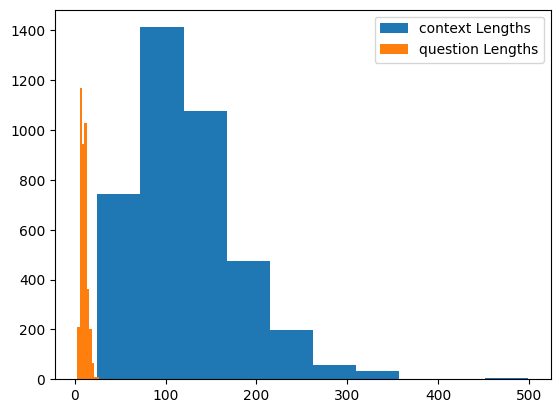

In [ ]:
import matplotlib.pyplot as plt

context_lengths = [len(context['context'].split()) for context in dataset_squad['train']]
question_lengths = [len(question['question'].split()) for question in dataset_squad['train']]

plt.hist(context_lengths, label = 'context Lengths')
plt.hist(question_lengths, label = 'question Lengths')
plt.legend()
plt.show()

In [ ]:
max_dialogue_length = max(context_lengths)
max_summary_length = max(question_lengths)

print(max_dialogue_length)
print(max_summary_length)

499
29


In [ ]:
from transformers import AutoTokenizer
model_checkpoint = "distilbert/distilbert-base-uncased"  #A multilingual version of T5, pretrained on the multilingual Common Crawl corpus (mC4), covering 101 languages.
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=384,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        answer = answers[i]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label it (0, 0)
        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [ ]:
tokenized_squad = dataset_squad.map(preprocess_function, batched=True, remove_columns=dataset_squad["train"].column_names)

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
print(tokenized_squad)

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 1000
    })
})


In [ ]:
from transformers import AutoModelForQuestionAnswering
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments

batch_size = 8
num_train_epochs = 3

# Show the training loss with every epoch
logging_steps = len(tokenized_squad["train"]) // batch_size #1841.25
print(logging_steps)

#default hyperparameters
args = TrainingArguments(
    output_dir="my_lab_task_qa_model",
    eval_strategy="epoch",
    learning_rate=5.6e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=3,  #only save up to 3 checkpoints during training
    num_train_epochs=num_train_epochs,
    logging_steps=logging_steps

)

500


In [ ]:
from transformers import DefaultDataCollator
data_collator = DefaultDataCollator()
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_squad["train"],
    eval_dataset=tokenized_squad["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,2.616200,1.517143
2,1.045100,1.313668
3,0.491800,1.520937


TrainOutput(global_step=1500, training_loss=1.3843651733398437, metrics={'train_runtime': 509.8832, 'train_samples_per_second': 23.535, 'train_steps_per_second': 2.942, 'total_flos': 1175877900288000.0, 'train_loss': 1.3843651733398437, 'epoch': 3.0})

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Assuming 'trainer' is your Trainer object and you want to save the model
trainer.save_model('/content/drive/My Drive/DistilBERT_SQUAD-3Epochs') #saved in account: maawa.kkhalid@gmail.com

Mounted at /content/drive


In [ ]:
trainer.evaluate()

{'eval_loss': 1.5209368467330933,
 'eval_runtime': 12.285,
 'eval_samples_per_second': 81.4,
 'eval_steps_per_second': 10.175,
 'epoch': 3.0}

In [ ]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=384318a73bf5af7a74e1481c89a6a88e5a8c047abaa7fbdc2f8a338b72e00d72
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [ ]:
import evaluate
rouge_score = evaluate.load("rouge")

In [ ]:
question = "What have they found?"
context = "Astronomers say that they have found a lunar cave which can be up to 100m deep and may be suitable for creating humanity’s permanent home on the Moon."

In [ ]:
from transformers import pipeline
model="/content/drive/MyDrive/DistilBERT_SQUAD-3Epochs"
question_answerer = pipeline("question-answering", model="/content/drive/MyDrive/DistilBERT_SQUAD-3Epochs")
question_answerer(question=question, context=context)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


{'score': 0.8472822308540344, 'start': 37, 'end': 49, 'answer': 'a lunar cave'}

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.6 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24

In [2]:
from datasets import load_dataset
dataset_squad = load_dataset("rajpurkar/squad", split = "train[:5000]", trust_remote_code=True)
dataset_squad = dataset_squad.train_test_split(test_size=0.2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [3]:
dataset_squad

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 1000
    })
})

In [4]:
print(dataset_squad['test'][14]['context'])
print(dataset_squad['test'][14]['question'])
dataset_squad['test'][14]['answers']

In the 18 years under the presidency of Edward Malloy, C.S.C., (1987–2005), there was a rapid growth in the school's reputation, faculty, and resources. He increased the faculty by more than 500 professors; the academic quality of the student body has improved dramatically, with the average SAT score rising from 1240 to 1360; the number of minority students more than doubled; the endowment grew from $350 million to more than $3 billion; the annual operating budget rose from $177 million to more than $650 million; and annual research funding improved from $15 million to more than $70 million. Notre Dame's most recent[when?] capital campaign raised $1.1 billion, far exceeding its goal of $767 million, and is the largest in the history of Catholic higher education.
During what years was Edward Malloy president of Notre Dame?


{'text': ['1987–2005'], 'answer_start': [64]}

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
from transformers import pipeline
from datasets import load_metric

In [10]:
question = dataset_squad['test'][3]['question']
context = dataset_squad['test'][3]['context']
ans = dataset_squad['test'][3]['answers']
print("Ground Truth :", ans)
model_path="/content/drive/MyDrive/DistilBERT_SQUAD-3Epochs"
question_answerer = pipeline("question-answering", model=model_path)
print ("Model Output :",question_answerer(question=question, context=context))

Ground Truth : {'text': ['Britney Spears, Pink, and Enrique Iglesias'], 'answer_start': [101]}
Model Output : {'score': 0.9717608094215393, 'start': 101, 'end': 143, 'answer': 'Britney Spears, Pink, and Enrique Iglesias'}


In [12]:
# Initialize the pipeline
model_path = "/content/drive/MyDrive/DistilBERT_SQUAD-3Epochs"
question_answerer = pipeline("question-answering", model=model_path)

# Load the SQuAD metric
metric = load_metric("squad")

# Iterate over the test set
predictions = []
references = []

for example in dataset_squad['test']:
    question = example['question']
    context = example['context']
    ground_truth = example['answers']['text'][0]

    # Get model prediction
    model_output = question_answerer(question=question, context=context)
    prediction = model_output['answer']

    # Prepare prediction and reference for the metric
    predictions.append({'id': example['id'], 'prediction_text': prediction})
    references.append({'id': example['id'], 'answers': example['answers']})

# Compute metrics
results = metric.compute(predictions=predictions, references=references)

# Print results
print(f"Exact Match: {results['exact_match']:.2f}")
print(f"F1 Score: {results['f1']:.2f}")

Exact Match: 86.10
F1 Score: 90.70


In [14]:
!pip install huggingface_hub --quiet

from huggingface_hub import HfApi, HfFolder, Repository

# Replace with your Hugging Face credentials


from huggingface_hub import HfApi, HfFolder, login
import os
import shutil

# Replace with your Hugging Face credentials
hf_username = 'MaawaKhalid'
hf_token = 'hf_tokenfromhuggingface_with_write_permissions'
model_repo_name = 'Extractive-QA-Model'

# Login to Hugging Face
login(token=hf_token)

# Authenticate with Hugging Face
api = HfApi()

# Create a new repository
repo_url = api.create_repo(repo_id=f'{hf_username}/{model_repo_name}', exist_ok=True)

# Define the local path to your model directory
local_model_dir = "/content/drive/MyDrive/DistilBERT_SQUAD-3Epochs"

# Clone the repository
os.system(f'git clone {repo_url} {model_repo_name}')

# Copy your model files to the cloned repository directory
dest_dir = os.path.join(model_repo_name, os.path.basename(local_model_dir))
shutil.copytree(local_model_dir, dest_dir, dirs_exist_ok=True)

# Change the current directory to the repository
os.chdir(model_repo_name)

# Add, commit, and push the files to the Hugging Face Hub
os.system('git add .')
os.system('git commit -m "Add model files"')
os.system('git push')

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful


32768

In [15]:
# Define the local path to your model directory
local_model_dir = "/content/drive/MyDrive/DistilBERT_SQUAD-3Epochs"

# Upload each file in the directory to the Hugging Face Hub
for root, dirs, files in os.walk(local_model_dir):
    for file in files:
        file_path = os.path.join(root, file)
        repo_file_path = os.path.relpath(file_path, local_model_dir)
        api.upload_file(
            path_or_fileobj=file_path,
            path_in_repo=repo_file_path,
            repo_id=f'{hf_username}/{model_repo_name}'
        )

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

# [Hugging Face Deoloyment Link]

https://huggingface.co/spaces/MaawaKhalid/Extractive-QA-Bot